In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B

In [2]:
start_time = '20160311T064700'
end_time = '20160311T064900'
satellite = 'A'
sdir = Path("D:/cleo/master/pyaw/data/swarm/miles2018")
sfn_efi16 = Path("efi16.pkl")
sfn_vfm50 = Path("vfm50.pkl")

In [3]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_efi16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_vfm50)

D:\cleo\master\pyaw\data\swarm\miles2018\efi16.pkl already exists, skip save.
D:\cleo\master\pyaw\data\swarm\miles2018\vfm50.pkl already exists, skip save.


In [4]:
df_e = pd.read_pickle(Path(sdir)/Path(sfn_efi16))
df_b = pd.read_pickle(Path(sdir)/Path(sfn_vfm50))

In [5]:
Timestamp_e = df_e.index.values
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values

In [6]:
theta = np.arctan(VsatE/VsatN)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
# Stack components to construct the rotation matrices
rotation_matrix = np.array([
    [cos_theta, sin_theta],
    [-sin_theta, cos_theta]
])
# Transpose axes to create a (3, 2, 2) array
rotation_matrix_2d_nec2vfm = np.transpose(rotation_matrix, (2, 0, 1))
rotation_matrix_2d_vfm2nec = rotation_matrix_2d_nec2vfm.transpose(0, 2, 1)
del rotation_matrix

In [7]:
def do_rotation(vectors1,vectors2,rotation_matrix):
    vectors12 = np.stack((vectors1,vectors2),axis=1)
    vectors12_rotated = np.einsum('nij,nj->ni', rotation_matrix, vectors12)
    return vectors12_rotated[:,0],vectors12_rotated[:,1]

In [8]:
Vsat_vfm_x,Vsat_vfm_y = do_rotation(VsatN,VsatE,rotation_matrix_2d_nec2vfm)
np.max(abs(Vsat_vfm_y)),np.all(np.isclose(Vsat_vfm_y,0,atol=1e-3))

(0.00012207031, True)

In [9]:
test_vsat_n,test_vsat_e = do_rotation(Vsat_vfm_x,Vsat_vfm_y,rotation_matrix_2d_vfm2nec)
np.max(abs(test_vsat_n - VsatN)),np.all(np.isclose(test_vsat_n - VsatN,0,atol=1e-3))

(0.0009765625, True)

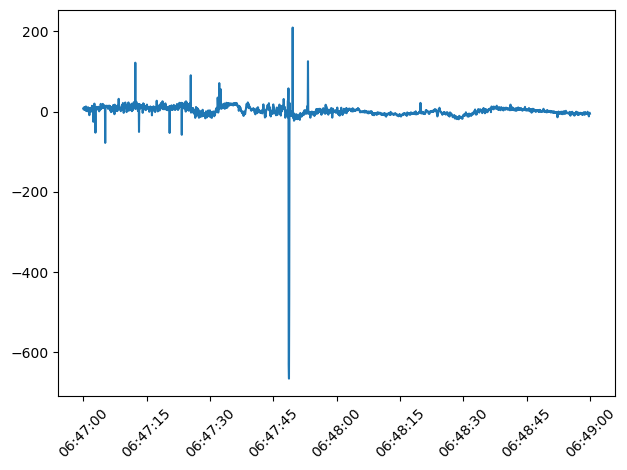

In [10]:
plt.plot(Timestamp_e,Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [13]:
np.std(Ehx),np.mean(Ehx),np.max(Ehx),np.min(Ehx)

(26.03453, 1.4860274, 209.64946, -665.1797)

In [25]:
def set_outliers_nan(array,std_times: float = 1.0, print_: bool = True):
    array_copy = array.copy()
    threshold = std_times * np.std(array_copy)
    bursts = np.abs(array_copy - np.mean(array_copy)) > threshold
    array_copy[bursts] = np.nan
    return array_copy

Ehx_set_outliers_nan = set_outliers_nan(Ehx)
Ehy_set_outliers_nan = set_outliers_nan(Ehy)

In [26]:
def get_array_interpolated(x,y):
    """
    :param x: ndarray consisting of np.datetime64. Specifically in this notebook the dtype of the array is np.datetime64[ns]
    :param y:
    :return:
    """
    y_copy = y
    # Mask for missing values
    mask = np.isnan(y_copy)
    # Interpolate
    y_copy[mask] = interpolate.interp1d(x[~mask].astype('int'), y_copy[~mask], kind='linear')(
        x[mask].astype('int'))
    return y_copy

In [27]:
Ehx_set_outliers_nan_interpolated = get_array_interpolated(Timestamp_e,Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = get_array_interpolated(Timestamp_e,Ehy_set_outliers_nan)